# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    output_layer = bilinear_upsample(small_ip_layer)
    # Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([output_layer, large_ip_layer])
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks.
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    skip_0 = inputs
    x = encoder_block(inputs, 32, 2)
    skip_1 = x
    x = encoder_block(x, 64, 2)
    skip_2 = x
    x = encoder_block(x, 128, 2)

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    x = conv2d_batchnorm(x, 256, kernel_size=1, strides=1)

    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = decoder_block(x, skip_2, 128)
    x = decoder_block(x, skip_1, 64)
    x = decoder_block(x, skip_0, 32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 64
num_epochs = 100
steps_per_epoch = 100
validation_steps = 50
workers = 2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 20, 128)       512       
__________

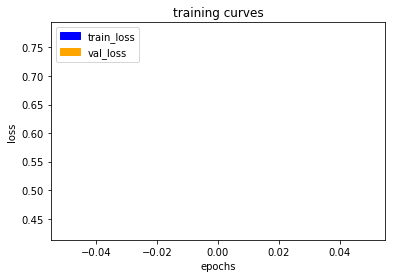

Epoch 00000: saving model to ../data/weights/weights.00.h5
100/100 [==============================] - 127s - loss: 0.7759 - val_loss: 0.4305
Epoch 2/100
 99/100 [============================>.] - ETA: 1s - loss: 0.2133

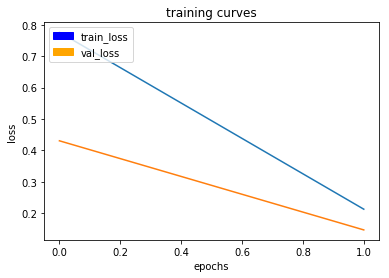

Epoch 00001: saving model to ../data/weights/weights.01.h5
100/100 [==============================] - 124s - loss: 0.2123 - val_loss: 0.1464
Epoch 3/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0828

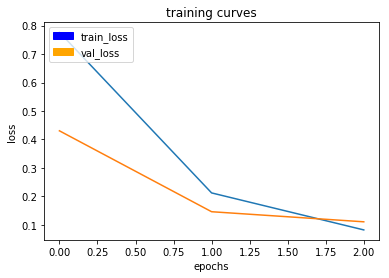

Epoch 00002: saving model to ../data/weights/weights.02.h5
100/100 [==============================] - 124s - loss: 0.0825 - val_loss: 0.1110
Epoch 4/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0551

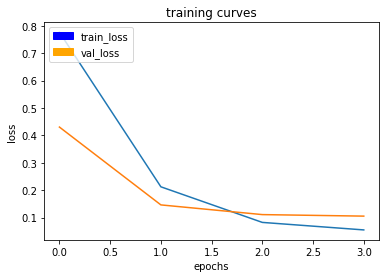

Epoch 00003: saving model to ../data/weights/weights.03.h5
100/100 [==============================] - 124s - loss: 0.0551 - val_loss: 0.1055
Epoch 5/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0438

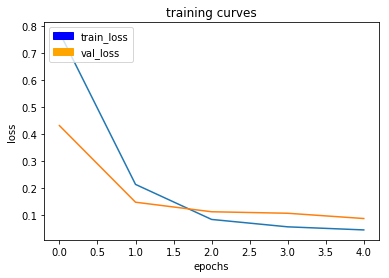

Epoch 00004: saving model to ../data/weights/weights.04.h5
100/100 [==============================] - 124s - loss: 0.0437 - val_loss: 0.0859
Epoch 6/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0378

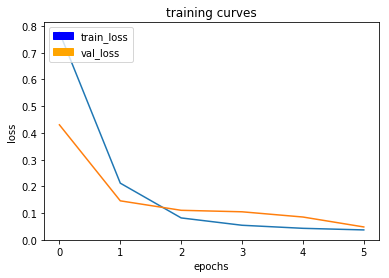

Epoch 00005: saving model to ../data/weights/weights.05.h5
100/100 [==============================] - 124s - loss: 0.0378 - val_loss: 0.0488
Epoch 7/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0337

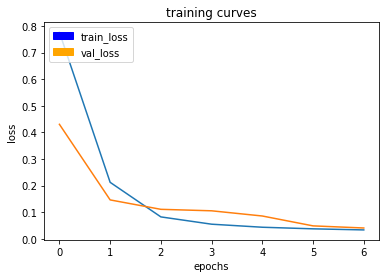

Epoch 00006: saving model to ../data/weights/weights.06.h5
100/100 [==============================] - 124s - loss: 0.0336 - val_loss: 0.0409
Epoch 8/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0297

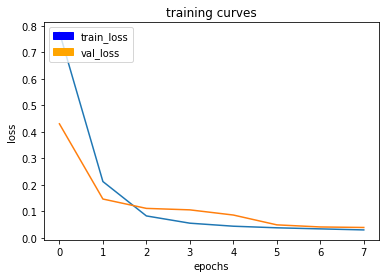

Epoch 00007: saving model to ../data/weights/weights.07.h5
100/100 [==============================] - 124s - loss: 0.0297 - val_loss: 0.0389
Epoch 9/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0286

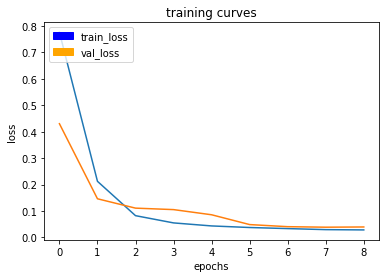

Epoch 00008: saving model to ../data/weights/weights.08.h5
100/100 [==============================] - 125s - loss: 0.0286 - val_loss: 0.0398
Epoch 10/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0269

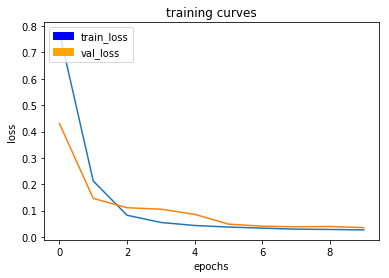

Epoch 00009: saving model to ../data/weights/weights.09.h5
100/100 [==============================] - 124s - loss: 0.0270 - val_loss: 0.0356
Epoch 11/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0248

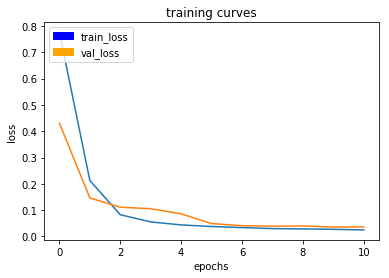

Epoch 00010: saving model to ../data/weights/weights.10.h5
100/100 [==============================] - 124s - loss: 0.0248 - val_loss: 0.0361
Epoch 12/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0234

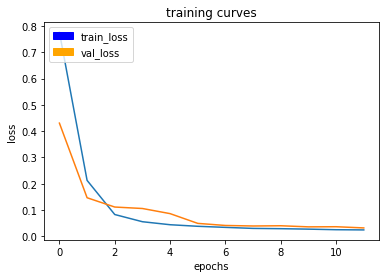

Epoch 00011: saving model to ../data/weights/weights.11.h5
100/100 [==============================] - 124s - loss: 0.0239 - val_loss: 0.0315
Epoch 13/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0225

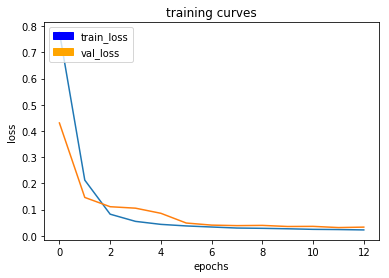

Epoch 00012: saving model to ../data/weights/weights.12.h5
100/100 [==============================] - 124s - loss: 0.0225 - val_loss: 0.0332
Epoch 14/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0222

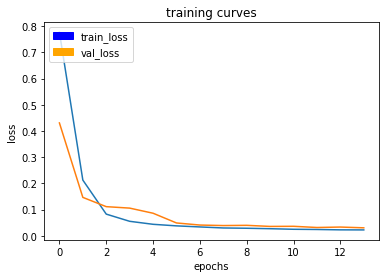

Epoch 00013: saving model to ../data/weights/weights.13.h5
100/100 [==============================] - 124s - loss: 0.0223 - val_loss: 0.0303
Epoch 15/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0203

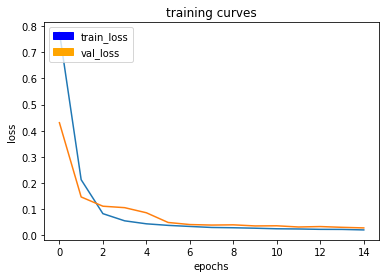

Epoch 00014: saving model to ../data/weights/weights.14.h5
100/100 [==============================] - 124s - loss: 0.0203 - val_loss: 0.0280
Epoch 16/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0200

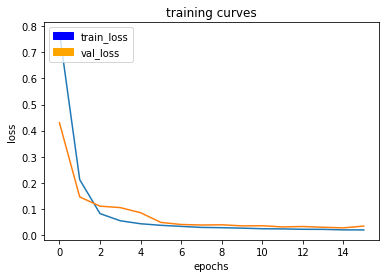

Epoch 00015: saving model to ../data/weights/weights.15.h5
100/100 [==============================] - 124s - loss: 0.0201 - val_loss: 0.0348
Epoch 17/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0196

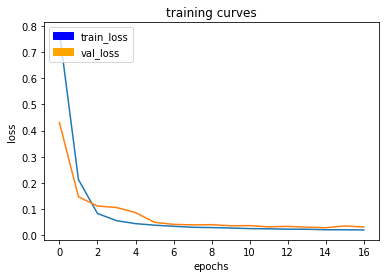

Epoch 00016: saving model to ../data/weights/weights.16.h5
100/100 [==============================] - 124s - loss: 0.0196 - val_loss: 0.0309
Epoch 18/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0185

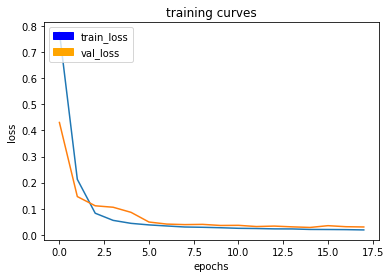

Epoch 00017: saving model to ../data/weights/weights.17.h5
100/100 [==============================] - 125s - loss: 0.0185 - val_loss: 0.0298
Epoch 19/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0188

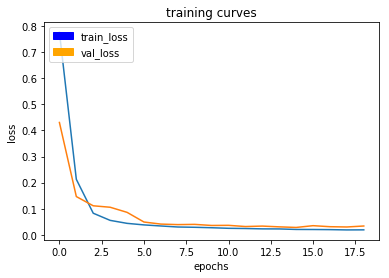

Epoch 00018: saving model to ../data/weights/weights.18.h5
100/100 [==============================] - 123s - loss: 0.0188 - val_loss: 0.0335
Epoch 20/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0175

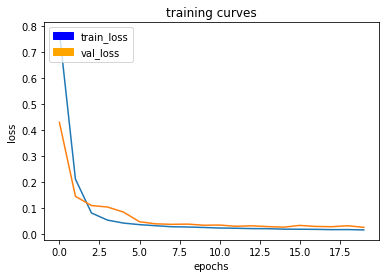

Epoch 00019: saving model to ../data/weights/weights.19.h5
100/100 [==============================] - 125s - loss: 0.0175 - val_loss: 0.0273
Epoch 21/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0168

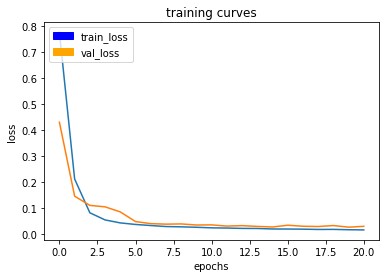

Epoch 00020: saving model to ../data/weights/weights.20.h5
100/100 [==============================] - 124s - loss: 0.0167 - val_loss: 0.0305
Epoch 22/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0171

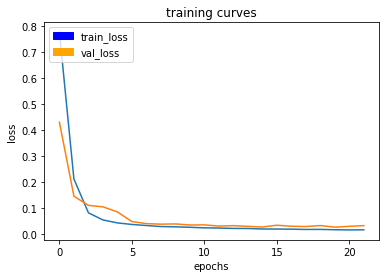

Epoch 00021: saving model to ../data/weights/weights.21.h5
100/100 [==============================] - 124s - loss: 0.0171 - val_loss: 0.0333
Epoch 23/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0159

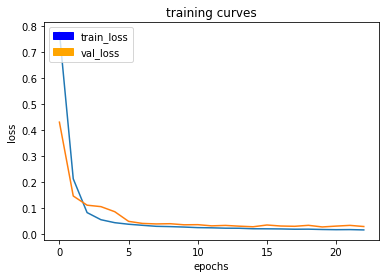

Epoch 00022: saving model to ../data/weights/weights.22.h5
100/100 [==============================] - 124s - loss: 0.0159 - val_loss: 0.0289
Epoch 24/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0185

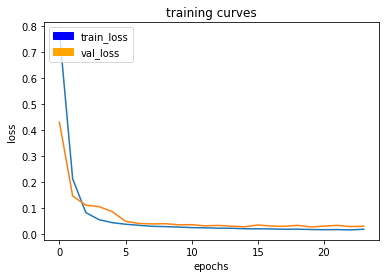

Epoch 00023: saving model to ../data/weights/weights.23.h5
100/100 [==============================] - 124s - loss: 0.0185 - val_loss: 0.0300
Epoch 25/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0173

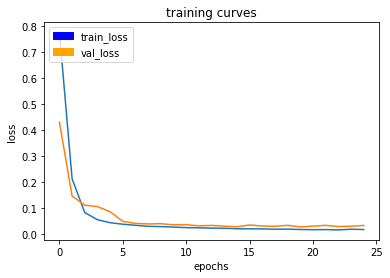

Epoch 00024: saving model to ../data/weights/weights.24.h5
100/100 [==============================] - 124s - loss: 0.0173 - val_loss: 0.0330
Epoch 26/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0166

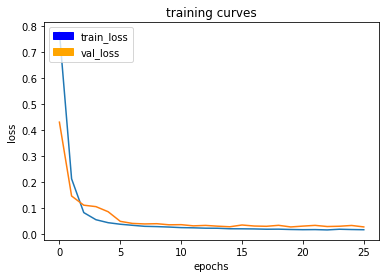

Epoch 00025: saving model to ../data/weights/weights.25.h5
100/100 [==============================] - 123s - loss: 0.0166 - val_loss: 0.0274
Epoch 27/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0173

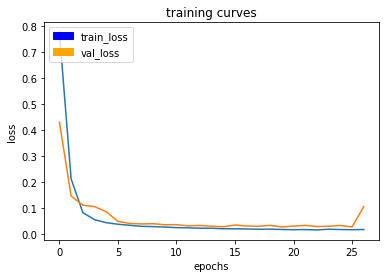

Epoch 00026: saving model to ../data/weights/weights.26.h5
100/100 [==============================] - 124s - loss: 0.0173 - val_loss: 0.1057
Epoch 28/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0168

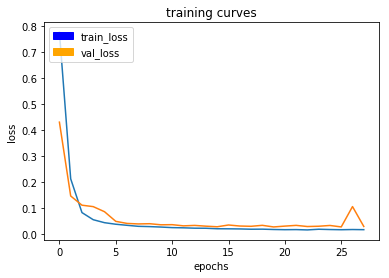

Epoch 00027: saving model to ../data/weights/weights.27.h5
100/100 [==============================] - 124s - loss: 0.0168 - val_loss: 0.0291
Epoch 29/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0144

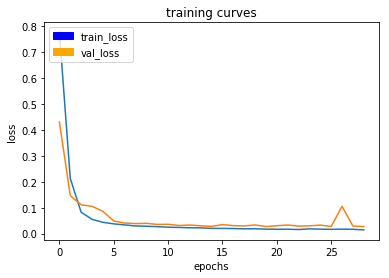

Epoch 00028: saving model to ../data/weights/weights.28.h5
100/100 [==============================] - 124s - loss: 0.0144 - val_loss: 0.0273
Epoch 30/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0142

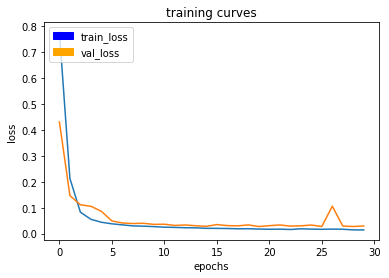

Epoch 00029: saving model to ../data/weights/weights.29.h5
100/100 [==============================] - 124s - loss: 0.0142 - val_loss: 0.0293
Epoch 31/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0137

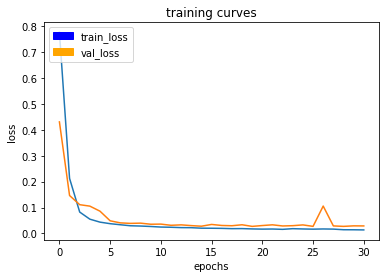

Epoch 00030: saving model to ../data/weights/weights.30.h5
100/100 [==============================] - 124s - loss: 0.0137 - val_loss: 0.0291
Epoch 32/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0136

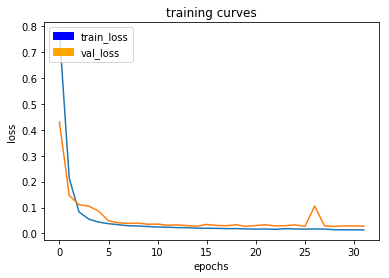

Epoch 00031: saving model to ../data/weights/weights.31.h5
100/100 [==============================] - 125s - loss: 0.0136 - val_loss: 0.0282
Epoch 33/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0132

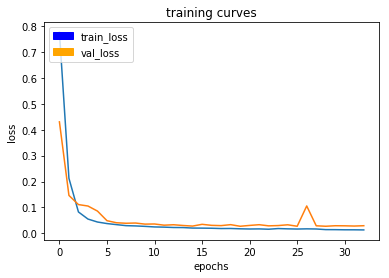

Epoch 00032: saving model to ../data/weights/weights.32.h5
100/100 [==============================] - 124s - loss: 0.0132 - val_loss: 0.0294
Epoch 34/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0128

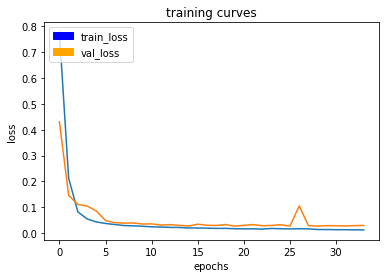

Epoch 00033: saving model to ../data/weights/weights.33.h5
100/100 [==============================] - 124s - loss: 0.0128 - val_loss: 0.0299
Epoch 35/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0140

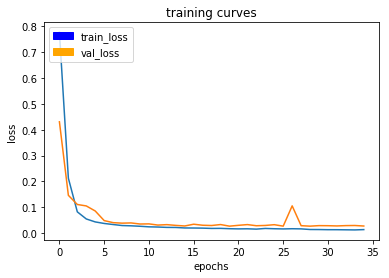

Epoch 00034: saving model to ../data/weights/weights.34.h5
100/100 [==============================] - 125s - loss: 0.0140 - val_loss: 0.0278
Epoch 36/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0143

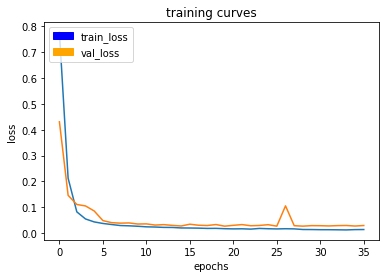

Epoch 00035: saving model to ../data/weights/weights.35.h5
100/100 [==============================] - 123s - loss: 0.0143 - val_loss: 0.0298
Epoch 37/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0128

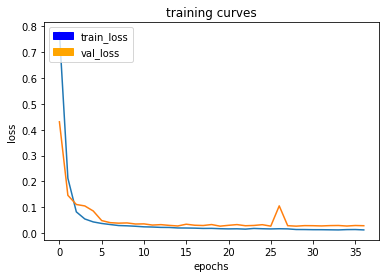

Epoch 00036: saving model to ../data/weights/weights.36.h5
100/100 [==============================] - 124s - loss: 0.0128 - val_loss: 0.0290
Epoch 38/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0131

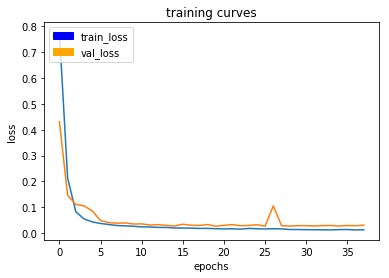

Epoch 00037: saving model to ../data/weights/weights.37.h5
100/100 [==============================] - 123s - loss: 0.0131 - val_loss: 0.0313
Epoch 39/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0135

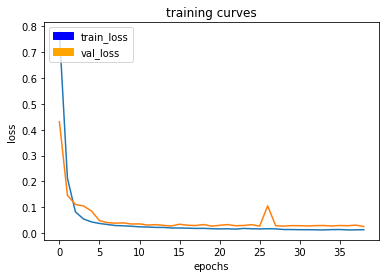

Epoch 00038: saving model to ../data/weights/weights.38.h5
100/100 [==============================] - 124s - loss: 0.0135 - val_loss: 0.0261
Epoch 40/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0123

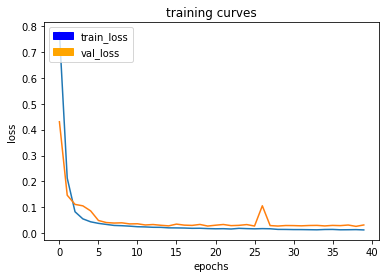

Epoch 00039: saving model to ../data/weights/weights.39.h5
100/100 [==============================] - 124s - loss: 0.0124 - val_loss: 0.0315
Epoch 41/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0117

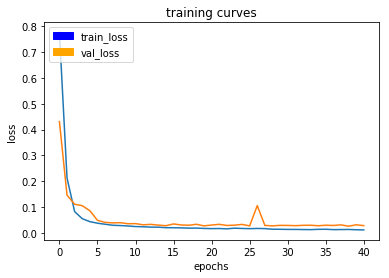

Epoch 00040: saving model to ../data/weights/weights.40.h5
100/100 [==============================] - 123s - loss: 0.0117 - val_loss: 0.0283
Epoch 42/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0116

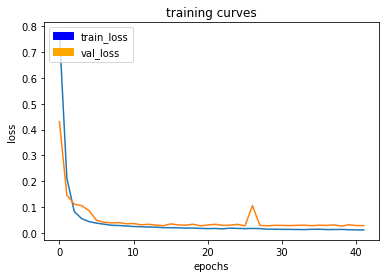

Epoch 00041: saving model to ../data/weights/weights.41.h5
100/100 [==============================] - 124s - loss: 0.0115 - val_loss: 0.0282
Epoch 43/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0119

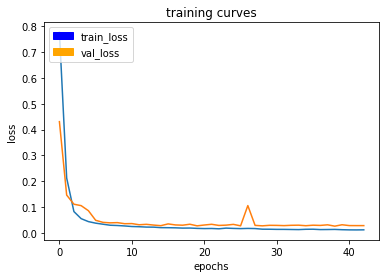

Epoch 00042: saving model to ../data/weights/weights.42.h5
100/100 [==============================] - 124s - loss: 0.0119 - val_loss: 0.0282
Epoch 44/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0115

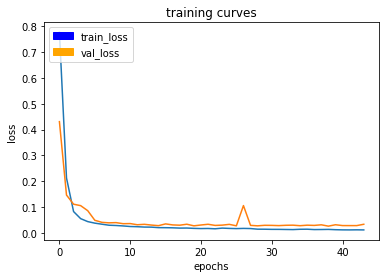

Epoch 00043: saving model to ../data/weights/weights.43.h5
100/100 [==============================] - 124s - loss: 0.0115 - val_loss: 0.0334
Epoch 45/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0123

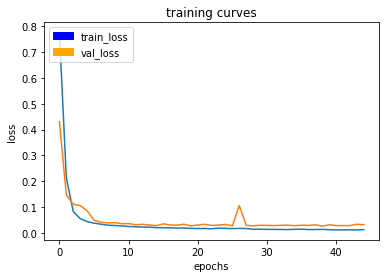

Epoch 00044: saving model to ../data/weights/weights.44.h5
100/100 [==============================] - 124s - loss: 0.0123 - val_loss: 0.0314
Epoch 46/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0148

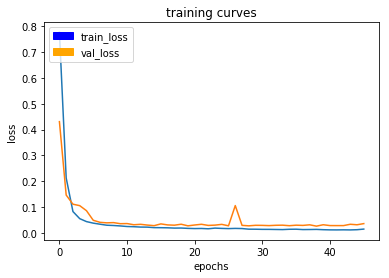

Epoch 00045: saving model to ../data/weights/weights.45.h5
100/100 [==============================] - 124s - loss: 0.0147 - val_loss: 0.0359
Epoch 47/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0135

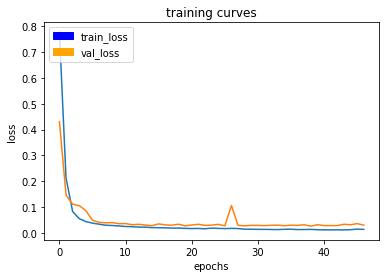

Epoch 00046: saving model to ../data/weights/weights.46.h5
100/100 [==============================] - 124s - loss: 0.0135 - val_loss: 0.0299
Epoch 48/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0116

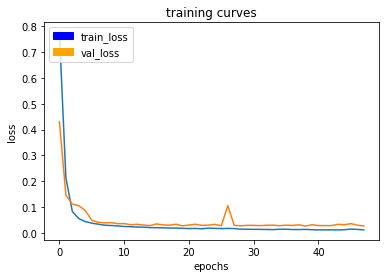

Epoch 00047: saving model to ../data/weights/weights.47.h5
100/100 [==============================] - 124s - loss: 0.0116 - val_loss: 0.0270
Epoch 49/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0119

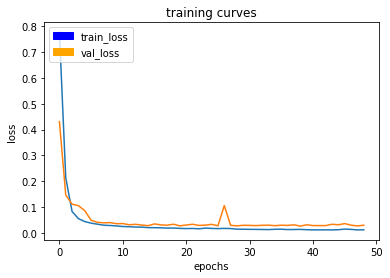

Epoch 00048: saving model to ../data/weights/weights.48.h5
100/100 [==============================] - 124s - loss: 0.0119 - val_loss: 0.0297
Epoch 50/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0117

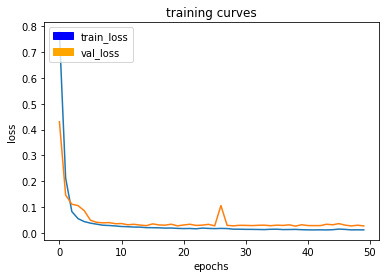

Epoch 00049: saving model to ../data/weights/weights.49.h5
100/100 [==============================] - 124s - loss: 0.0117 - val_loss: 0.0271
Epoch 51/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0117

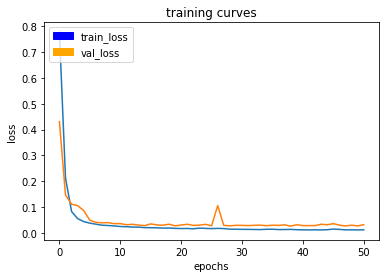

Epoch 00050: saving model to ../data/weights/weights.50.h5
100/100 [==============================] - 124s - loss: 0.0117 - val_loss: 0.0317
Epoch 52/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0111

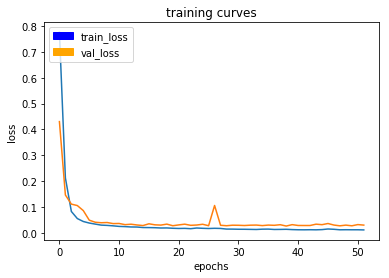

Epoch 00051: saving model to ../data/weights/weights.51.h5
100/100 [==============================] - 124s - loss: 0.0111 - val_loss: 0.0298
Epoch 53/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0107

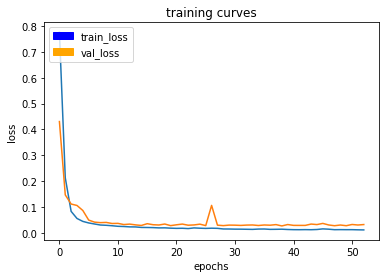

Epoch 00052: saving model to ../data/weights/weights.52.h5
100/100 [==============================] - 125s - loss: 0.0107 - val_loss: 0.0315
Epoch 54/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0105

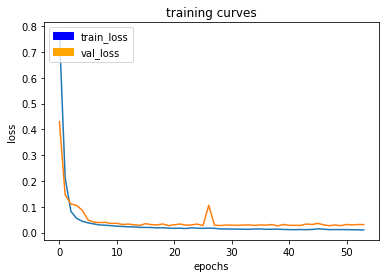

Epoch 00053: saving model to ../data/weights/weights.53.h5
100/100 [==============================] - 124s - loss: 0.0105 - val_loss: 0.0310
Epoch 55/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0103

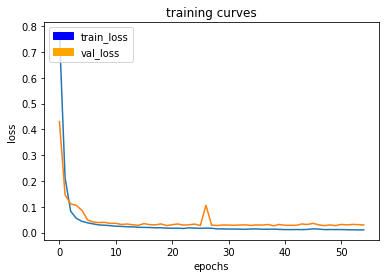

Epoch 00054: saving model to ../data/weights/weights.54.h5
100/100 [==============================] - 124s - loss: 0.0103 - val_loss: 0.0295
Epoch 56/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0107

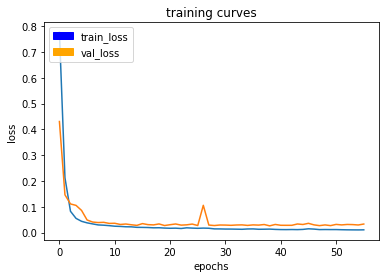

Epoch 00055: saving model to ../data/weights/weights.55.h5
100/100 [==============================] - 124s - loss: 0.0107 - val_loss: 0.0331
Epoch 57/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0104

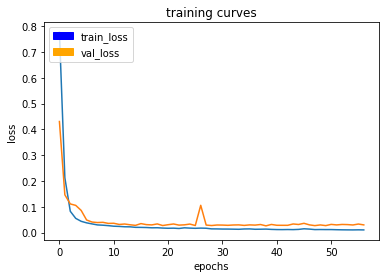

Epoch 00056: saving model to ../data/weights/weights.56.h5
100/100 [==============================] - 125s - loss: 0.0103 - val_loss: 0.0298
Epoch 58/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0111

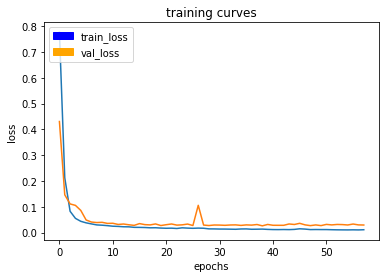

Epoch 00057: saving model to ../data/weights/weights.57.h5
100/100 [==============================] - 124s - loss: 0.0111 - val_loss: 0.0293
Epoch 59/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0110

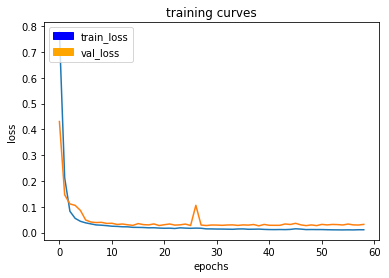

Epoch 00058: saving model to ../data/weights/weights.58.h5
100/100 [==============================] - 124s - loss: 0.0110 - val_loss: 0.0317
Epoch 60/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0108

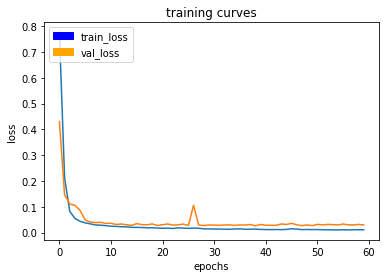

Epoch 00059: saving model to ../data/weights/weights.59.h5
100/100 [==============================] - 124s - loss: 0.0108 - val_loss: 0.0292
Epoch 61/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0111

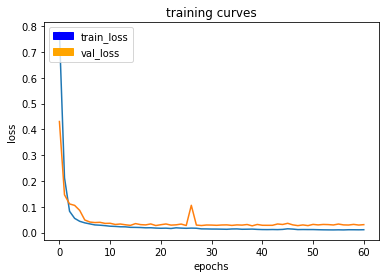

Epoch 00060: saving model to ../data/weights/weights.60.h5
100/100 [==============================] - 125s - loss: 0.0111 - val_loss: 0.0308
Epoch 62/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0100

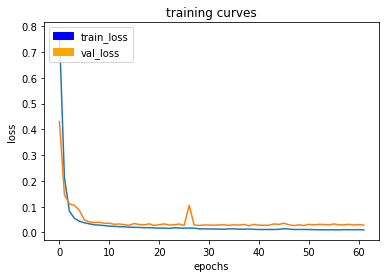

Epoch 00061: saving model to ../data/weights/weights.61.h5
100/100 [==============================] - 124s - loss: 0.0100 - val_loss: 0.0287
Epoch 63/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0100

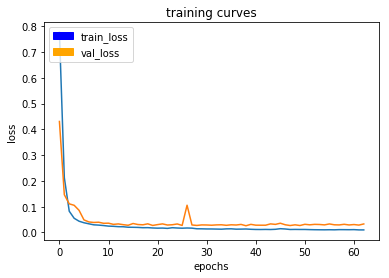

Epoch 00062: saving model to ../data/weights/weights.62.h5
100/100 [==============================] - 124s - loss: 0.0099 - val_loss: 0.0331
Epoch 64/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0102

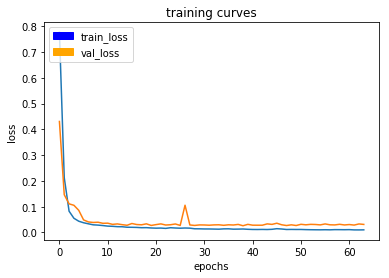

Epoch 00063: saving model to ../data/weights/weights.63.h5
100/100 [==============================] - 124s - loss: 0.0102 - val_loss: 0.0313
Epoch 65/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0117

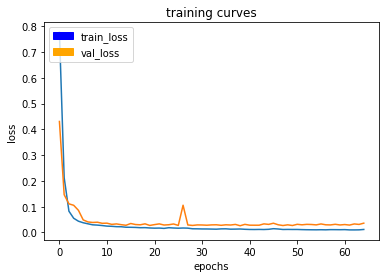

Epoch 00064: saving model to ../data/weights/weights.64.h5
100/100 [==============================] - 123s - loss: 0.0117 - val_loss: 0.0361
Epoch 66/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0138

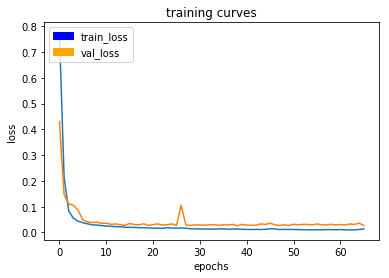

Epoch 00065: saving model to ../data/weights/weights.65.h5
100/100 [==============================] - 124s - loss: 0.0138 - val_loss: 0.0269
Epoch 67/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0113

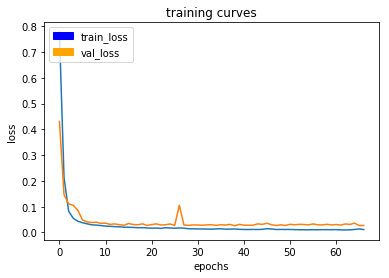

Epoch 00066: saving model to ../data/weights/weights.66.h5
100/100 [==============================] - 131s - loss: 0.0113 - val_loss: 0.0274
Epoch 68/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0138

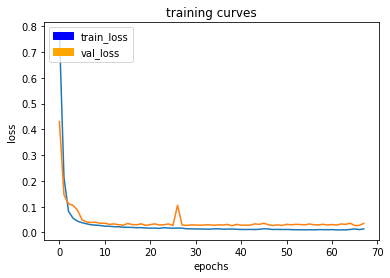

Epoch 00067: saving model to ../data/weights/weights.67.h5
100/100 [==============================] - 125s - loss: 0.0138 - val_loss: 0.0352
Epoch 69/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0130

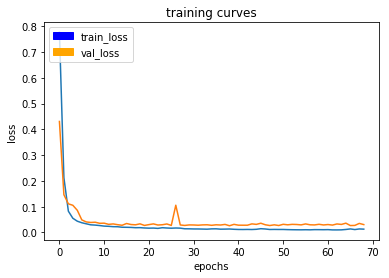

Epoch 00068: saving model to ../data/weights/weights.68.h5
100/100 [==============================] - 124s - loss: 0.0129 - val_loss: 0.0306
Epoch 70/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0104

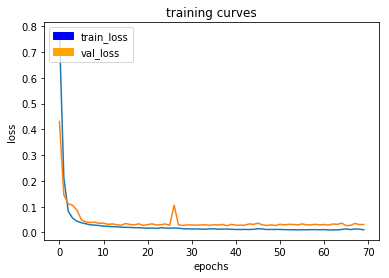

Epoch 00069: saving model to ../data/weights/weights.69.h5
100/100 [==============================] - 124s - loss: 0.0104 - val_loss: 0.0312
Epoch 71/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0099

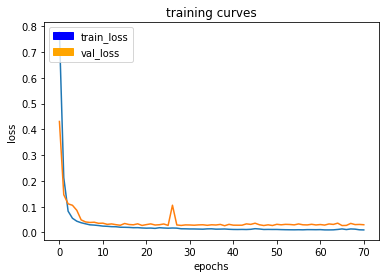

Epoch 00070: saving model to ../data/weights/weights.70.h5
100/100 [==============================] - 124s - loss: 0.0099 - val_loss: 0.0300
Epoch 72/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0097

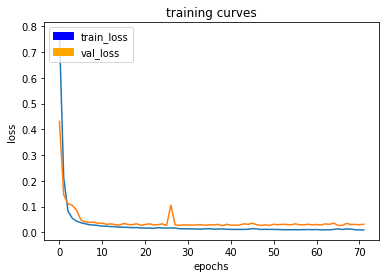

Epoch 00071: saving model to ../data/weights/weights.71.h5
100/100 [==============================] - 124s - loss: 0.0097 - val_loss: 0.0314
Epoch 73/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0096

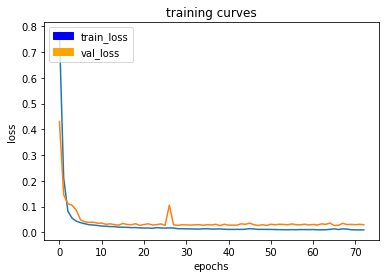

Epoch 00072: saving model to ../data/weights/weights.72.h5
100/100 [==============================] - 123s - loss: 0.0096 - val_loss: 0.0297
Epoch 74/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0095

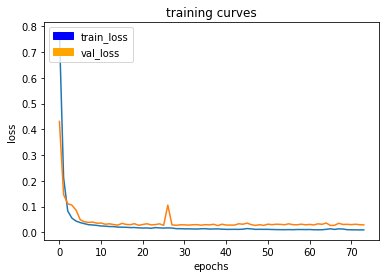

Epoch 00073: saving model to ../data/weights/weights.73.h5
100/100 [==============================] - 124s - loss: 0.0095 - val_loss: 0.0290
Epoch 75/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0093

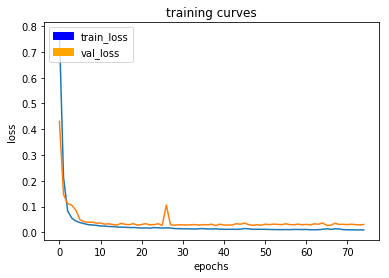

Epoch 00074: saving model to ../data/weights/weights.74.h5
100/100 [==============================] - 124s - loss: 0.0093 - val_loss: 0.0304
Epoch 76/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0093

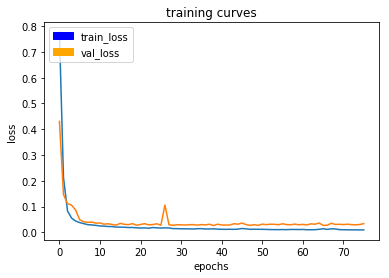

Epoch 00075: saving model to ../data/weights/weights.75.h5
100/100 [==============================] - 124s - loss: 0.0093 - val_loss: 0.0335
Epoch 77/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0092

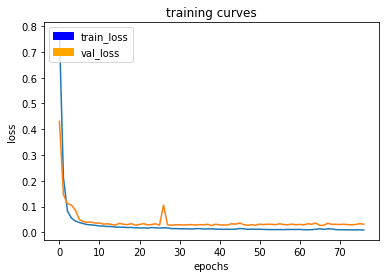

Epoch 00076: saving model to ../data/weights/weights.76.h5
100/100 [==============================] - 124s - loss: 0.0092 - val_loss: 0.0313
Epoch 78/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0091

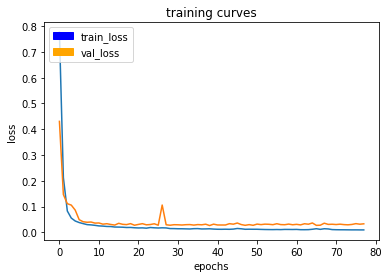

Epoch 00077: saving model to ../data/weights/weights.77.h5
100/100 [==============================] - 124s - loss: 0.0091 - val_loss: 0.0328
Epoch 79/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0091

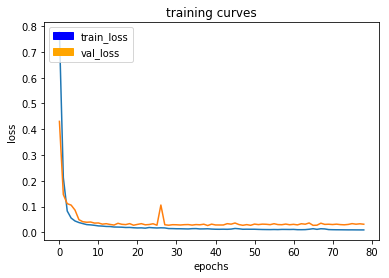

Epoch 00078: saving model to ../data/weights/weights.78.h5
100/100 [==============================] - 124s - loss: 0.0091 - val_loss: 0.0312
Epoch 80/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0090

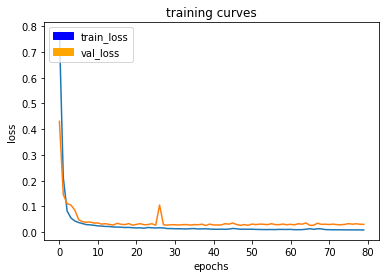

Epoch 00079: saving model to ../data/weights/weights.79.h5
100/100 [==============================] - 124s - loss: 0.0090 - val_loss: 0.0305
Epoch 81/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0089

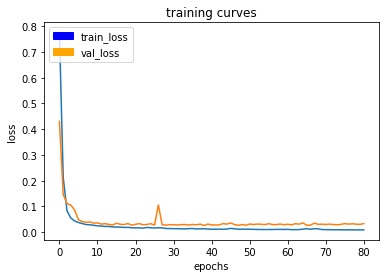

Epoch 00080: saving model to ../data/weights/weights.80.h5
100/100 [==============================] - 124s - loss: 0.0089 - val_loss: 0.0332
Epoch 82/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0092

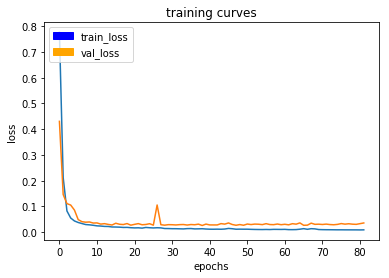

Epoch 00081: saving model to ../data/weights/weights.81.h5
100/100 [==============================] - 124s - loss: 0.0092 - val_loss: 0.0359
Epoch 83/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0092

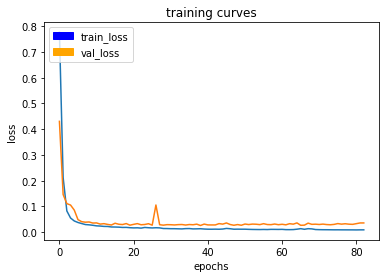

Epoch 00082: saving model to ../data/weights/weights.82.h5
100/100 [==============================] - 124s - loss: 0.0092 - val_loss: 0.0360
Epoch 84/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0092

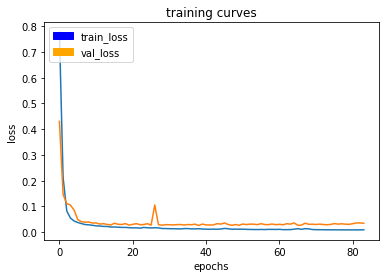

Epoch 00083: saving model to ../data/weights/weights.83.h5
100/100 [==============================] - 124s - loss: 0.0093 - val_loss: 0.0348
Epoch 85/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0129

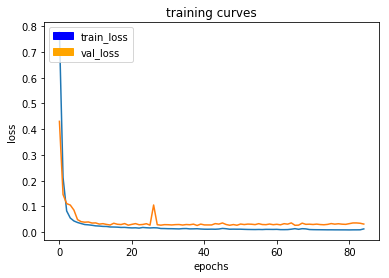

Epoch 00084: saving model to ../data/weights/weights.84.h5
100/100 [==============================] - 124s - loss: 0.0129 - val_loss: 0.0317
Epoch 86/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0124

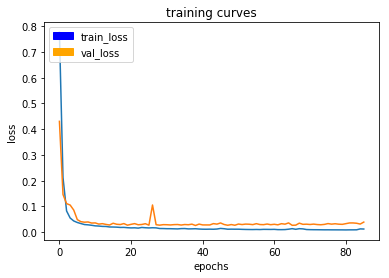

Epoch 00085: saving model to ../data/weights/weights.85.h5
100/100 [==============================] - 124s - loss: 0.0124 - val_loss: 0.0393
Epoch 87/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0112

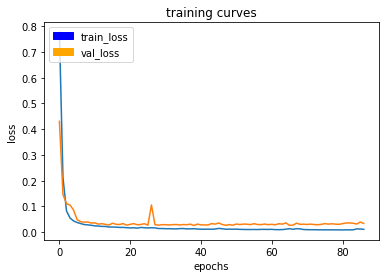

Epoch 00086: saving model to ../data/weights/weights.86.h5
100/100 [==============================] - 125s - loss: 0.0112 - val_loss: 0.0342
Epoch 88/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0097

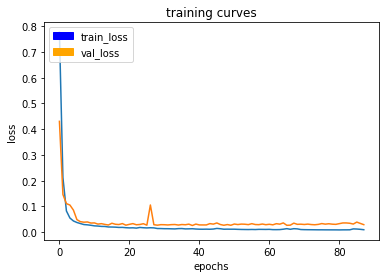

Epoch 00087: saving model to ../data/weights/weights.87.h5
100/100 [==============================] - 124s - loss: 0.0097 - val_loss: 0.0293
Epoch 89/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0093

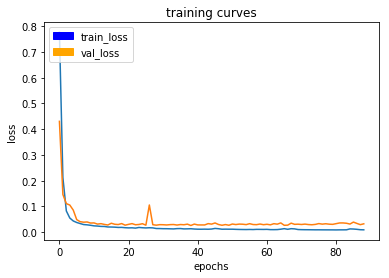

Epoch 00088: saving model to ../data/weights/weights.88.h5
100/100 [==============================] - 124s - loss: 0.0093 - val_loss: 0.0326
Epoch 90/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0090

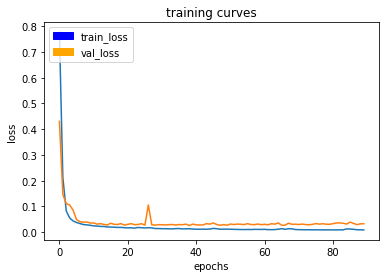

Epoch 00089: saving model to ../data/weights/weights.89.h5
100/100 [==============================] - 124s - loss: 0.0090 - val_loss: 0.0328
Epoch 91/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0089

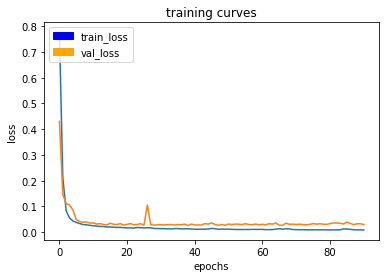

Epoch 00090: saving model to ../data/weights/weights.90.h5
100/100 [==============================] - 124s - loss: 0.0089 - val_loss: 0.0298
Epoch 92/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0088

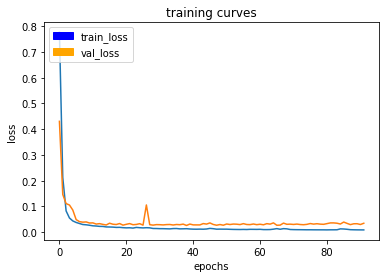

Epoch 00091: saving model to ../data/weights/weights.91.h5
100/100 [==============================] - 124s - loss: 0.0088 - val_loss: 0.0346
Epoch 93/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0086

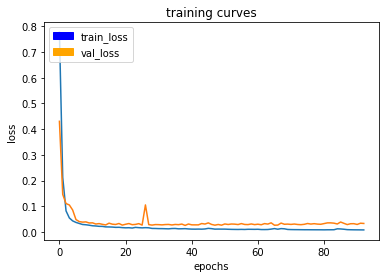

Epoch 00092: saving model to ../data/weights/weights.92.h5
100/100 [==============================] - 124s - loss: 0.0086 - val_loss: 0.0337
Epoch 94/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0089

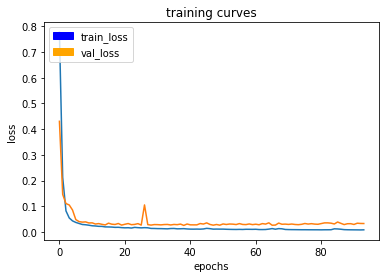

Epoch 00093: saving model to ../data/weights/weights.93.h5
100/100 [==============================] - 125s - loss: 0.0089 - val_loss: 0.0334
Epoch 95/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0088

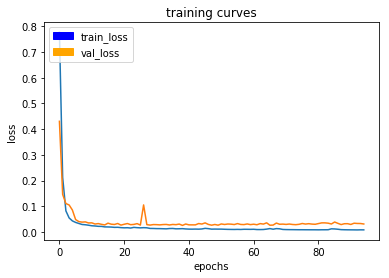

Epoch 00094: saving model to ../data/weights/weights.94.h5
100/100 [==============================] - 124s - loss: 0.0088 - val_loss: 0.0316
Epoch 96/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0087

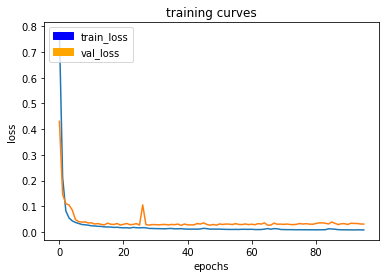

Epoch 00095: saving model to ../data/weights/weights.95.h5
100/100 [==============================] - 124s - loss: 0.0086 - val_loss: 0.0313
Epoch 97/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0086

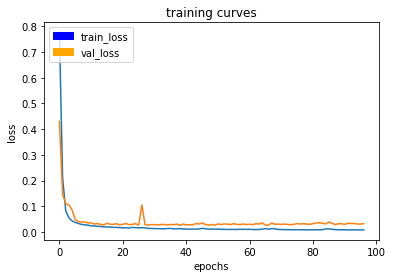

Epoch 00096: saving model to ../data/weights/weights.96.h5
100/100 [==============================] - 124s - loss: 0.0086 - val_loss: 0.0328
Epoch 98/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0086

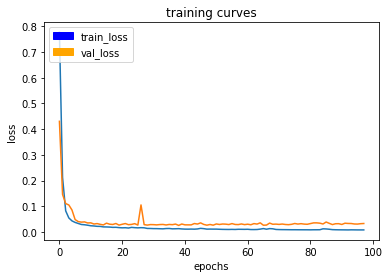

Epoch 00097: saving model to ../data/weights/weights.97.h5
100/100 [==============================] - 124s - loss: 0.0086 - val_loss: 0.0335
Epoch 99/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0085

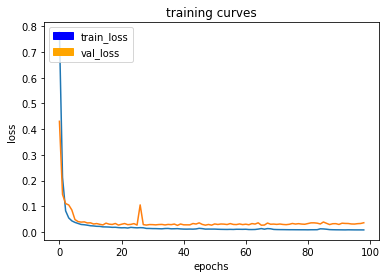

Epoch 00098: saving model to ../data/weights/weights.98.h5
100/100 [==============================] - 124s - loss: 0.0085 - val_loss: 0.0364
Epoch 100/100
 99/100 [============================>.] - ETA: 1s - loss: 0.0117

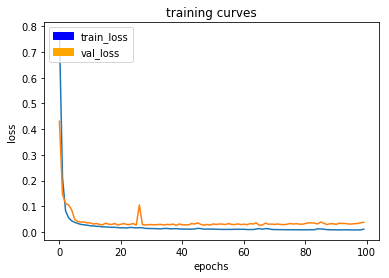

Epoch 00099: saving model to ../data/weights/weights.99.h5
100/100 [==============================] - 124s - loss: 0.0117 - val_loss: 0.0382


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
print(model.summary())
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Save your pre-trained model
weight_file_name = 'model_eval'
model_tools.save_network(model, weight_file_name)

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
checkpointer = keras.callbacks.ModelCheckpoint('../data/weights/weights.{epoch:02d}.h5',
                                               verbose=1)
callbacks = [logger_cb, checkpointer]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [22]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

#weight_file_name = 'model_weights'
#model = model_tools.load_network(weight_file_name)
weights_path = "../data/weights/weights.38.h5"
model.load_weights(weights_path)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [23]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

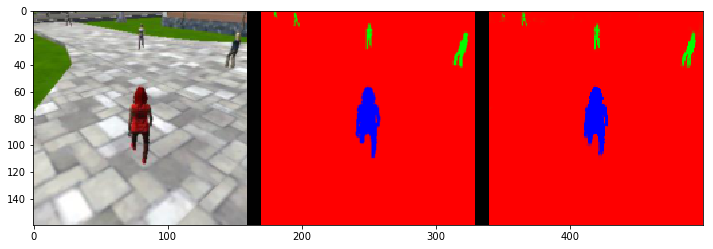

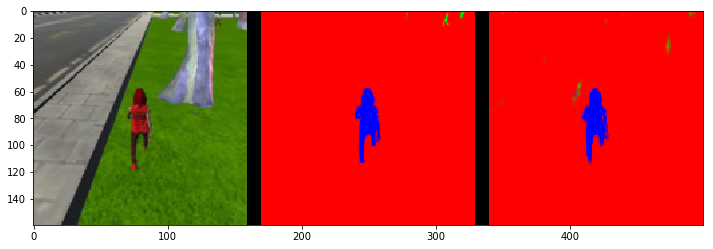

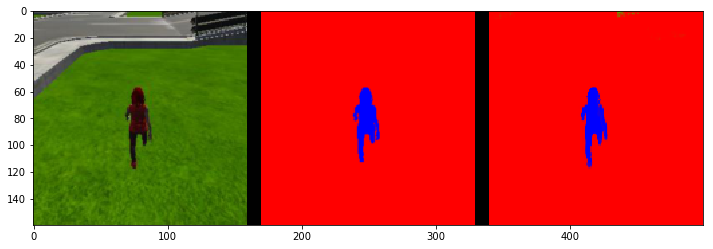

In [24]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

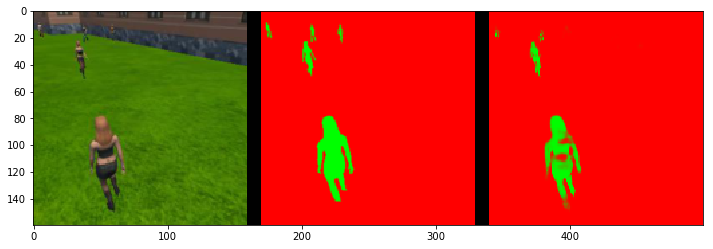

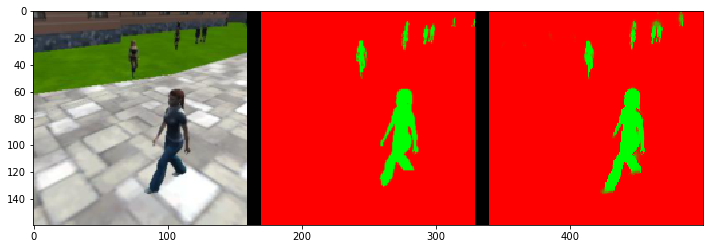

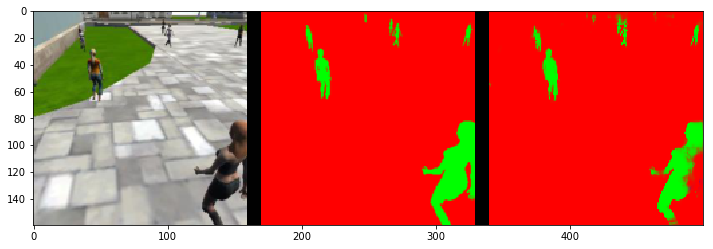

In [25]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

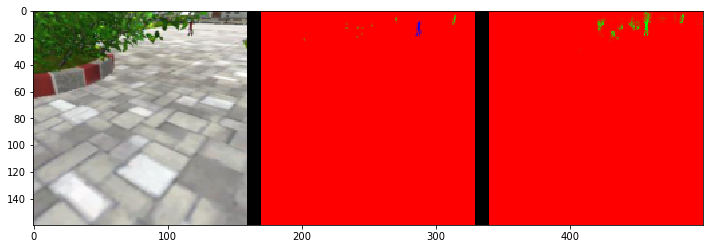

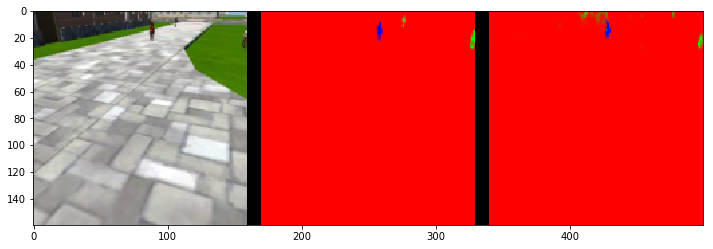

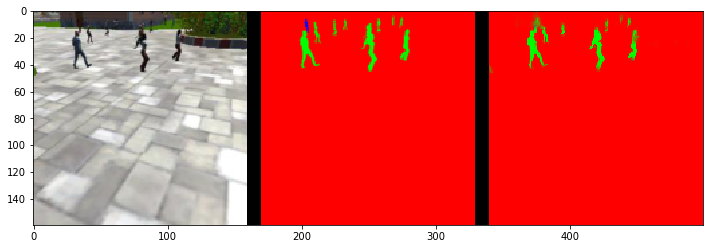

In [26]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [27]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9955804361003607
average intersection over union for other people is 0.36600193316722945
average intersection over union for the hero is 0.9114257343742999
number true positives: 539, number false positives: 0, number false negatives: 0


In [28]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9875939468755763
average intersection over union for other people is 0.7446399672908006
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 49, number false negatives: 0


In [29]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9964425850194518
average intersection over union for other people is 0.44935496423940374
average intersection over union for the hero is 0.22665011788661515
number true positives: 120, number false positives: 1, number false negatives: 181


In [30]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7404494382022472


In [31]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.56903792613


In [32]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.421343812719
